### Implemention a VAE to generate new images of handwritten digits.

#### Import the relevant packages and define the device

In [1]:
from torch_snippets import *
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Define the transformation required for the images 

In [2]:
images_tranform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,)),
                                      transforms.Lambda(lambda x: x.to(device))])

#### Define the training and validation dataset

In [3]:
datafolder = 'dataset/'
train_dataset = MNIST(datafolder, train=True, download=True, transform=images_tranform)
valid_dataset = MNIST(datafolder, train=False, download=True, transform=images_tranform)

#### Define the dataloader

In [5]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### Define the network architecture 

In [6]:
class ConvAutoEncoder(nn.Module):

    def __init__(self) :
        super().__init__()

        self.encoder = nn.Sequential(
                                    nn.Conv2d(1, 32, 3, stride=3, padding=1),
                                    nn.ReLU(True),
                                    nn.MaxPool2d(2, stride=2),
                                    nn.Conv2d(32, 64, 3, stride=2, padding=1),
                                    nn.ReLU(True),
                                    nn.MaxPool2d(2, stride=1))

        self.decoder = nn.Sequential(
                                    nn.ConvTranspose2d(64, 32, 3, stride=2),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),
                                    nn.Tanh()
                                    )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#### Visualize the preceding model

In [9]:
from torchsummary import summary
model = ConvAutoEncoder().to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 10, 10]             320
              ReLU-2           [-1, 32, 10, 10]               0
         MaxPool2d-3             [-1, 32, 5, 5]               0
            Conv2d-4             [-1, 64, 3, 3]          18,496
              ReLU-5             [-1, 64, 3, 3]               0
         MaxPool2d-6             [-1, 64, 2, 2]               0
   ConvTranspose2d-7             [-1, 32, 5, 5]          18,464
              ReLU-8             [-1, 32, 5, 5]               0
   ConvTranspose2d-9           [-1, 16, 15, 15]          12,816
             ReLU-10           [-1, 16, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              65
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 50,161
Trainable params: 50,161
Non-trainable params: 0
---------------------------------

### Define the training function

In [10]:
def train_batch(input, model, loss, opimizer):
    model.train()
    opimizer.zero_grad()
    output = model(input)
    loss = loss(output, input)
    loss.backward()
    opimizer.step()
    return loss.item()

#### Define the validation function

In [11]:
@torch.no_grad()
def valid_batch(input, model, loss):
    model.eval()
    output = model(input)
    loss = loss(output, input)
    return loss.item()

#### Define the optimizer and loss function

In [12]:
optimizer  = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn    = nn.MSELoss()

#### Train the models over epochs

In [13]:
num_epoch = 25
log = Report(num_epoch)

for epoch in range(num_epoch):
    N = len(train_dataloader)
    for ix, (data, _) in enumerate(train_dataloader):
        loss = train_batch(data, model, loss_fn, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(valid_dataloader)
    for ix, (data, _) in enumerate(valid_dataloader):
        loss = valid_batch(data, model, loss_fn)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.101  trn_loss: 0.196  (13.18s - 316.37s remaining)
EPOCH: 2.000  val_loss: 0.074  trn_loss: 0.087  (25.05s - 288.11s remaining)
EPOCH: 3.000  val_loss: 0.065  trn_loss: 0.072  (37.03s - 271.54s remaining)
EPOCH: 4.000  val_loss: 0.060  trn_loss: 0.064  (48.84s - 256.38s remaining)
EPOCH: 5.000  val_loss: 0.056  trn_loss: 0.060  (60.63s - 242.54s remaining)
EPOCH: 6.000  val_loss: 0.054  trn_loss: 0.057  (72.41s - 229.29s remaining)
EPOCH: 7.000  val_loss: 0.052  trn_loss: 0.055  (84.75s - 217.93s remaining)
EPOCH: 8.000  val_loss: 0.051  trn_loss: 0.053  (96.69s - 205.46s remaining)
EPOCH: 9.000  val_loss: 0.049  trn_loss: 0.051  (108.65s - 193.15s remaining)
EPOCH: 10.000  val_loss: 0.048  trn_loss: 0.050  (120.72s - 181.08s remaining)
EPOCH: 11.000  val_loss: 0.047  trn_loss: 0.049  (132.77s - 168.98s remaining)
EPOCH: 12.000  val_loss: 0.046  trn_loss: 0.048  (144.86s - 156.93s remaining)
EPOCH: 13.000  val_loss: 0.046  trn_loss: 0.047  (157.07s - 144.99s r

#### Visualize the training and validation loss

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:00<00:00, 402.17it/s]


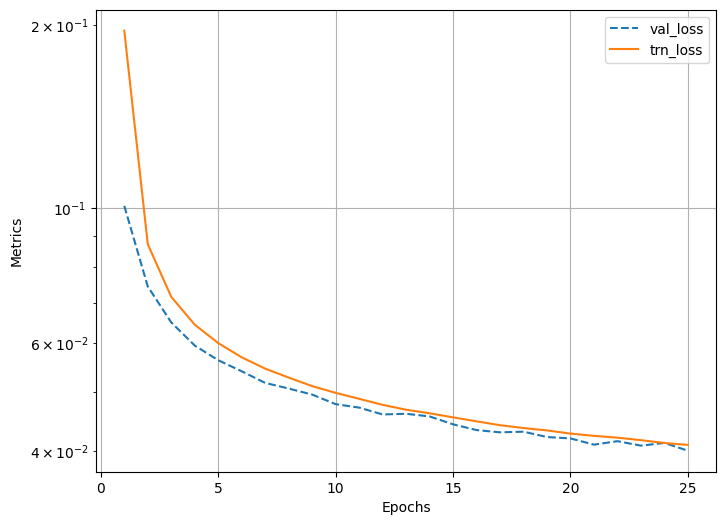

In [14]:
log.plot_epochs(log=True)

#### Validate the model on the validation dataset

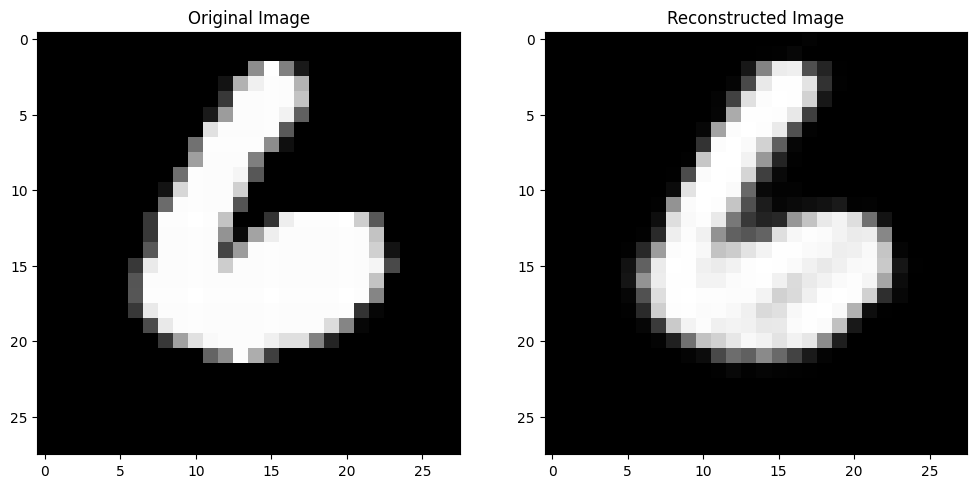

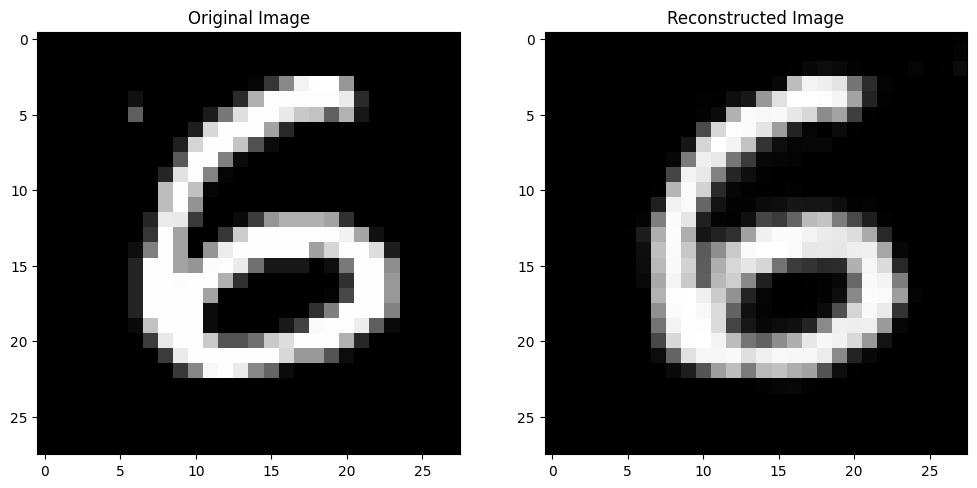

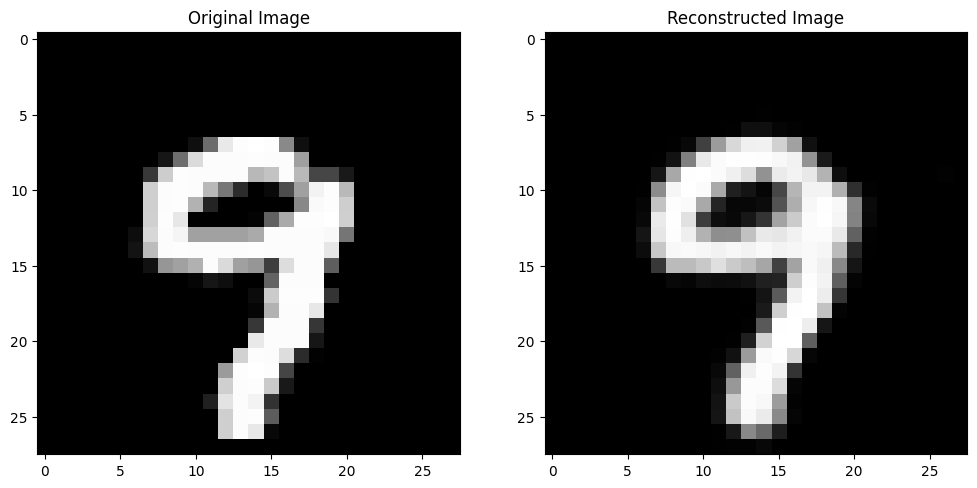

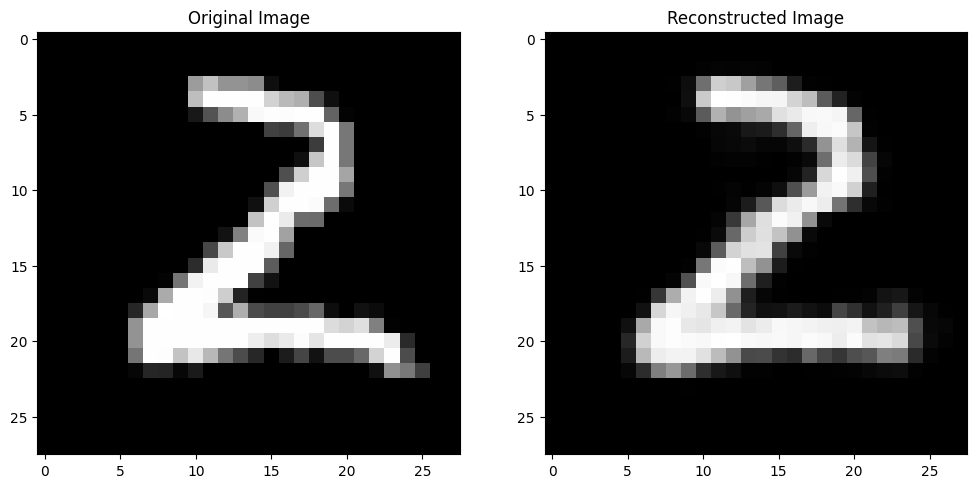

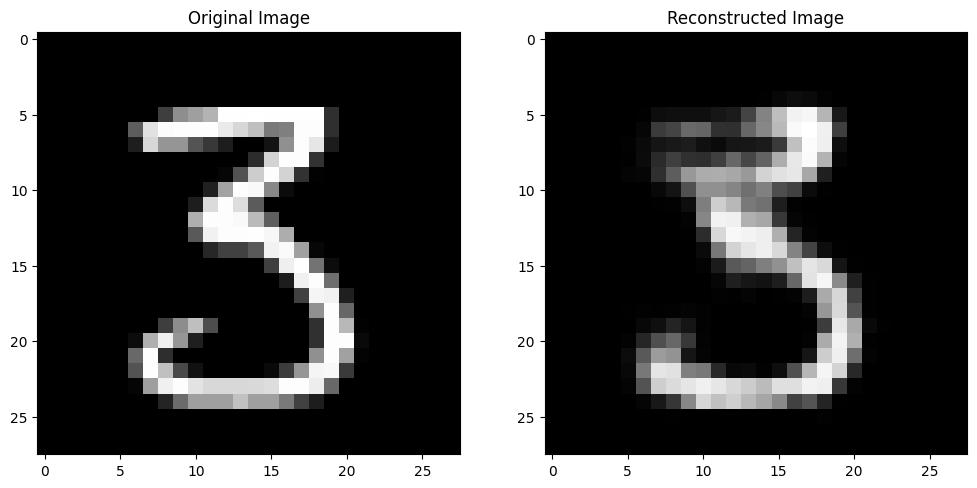

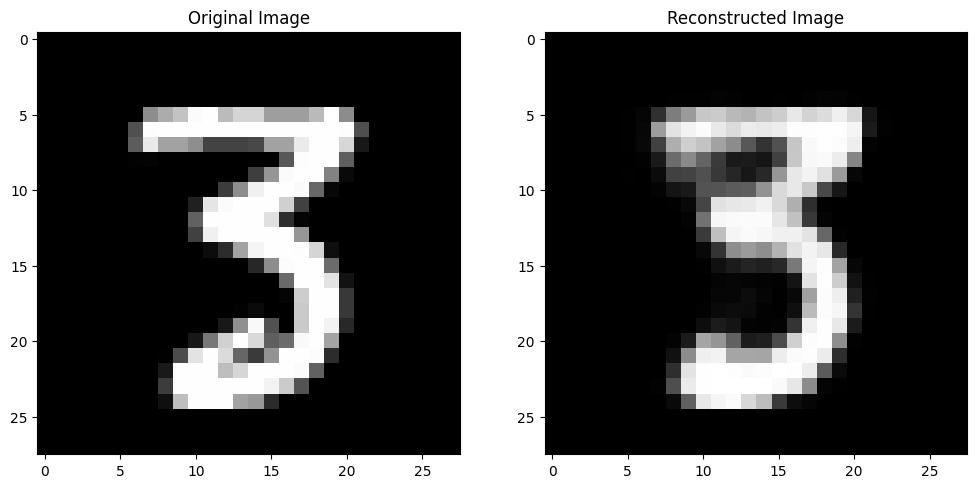

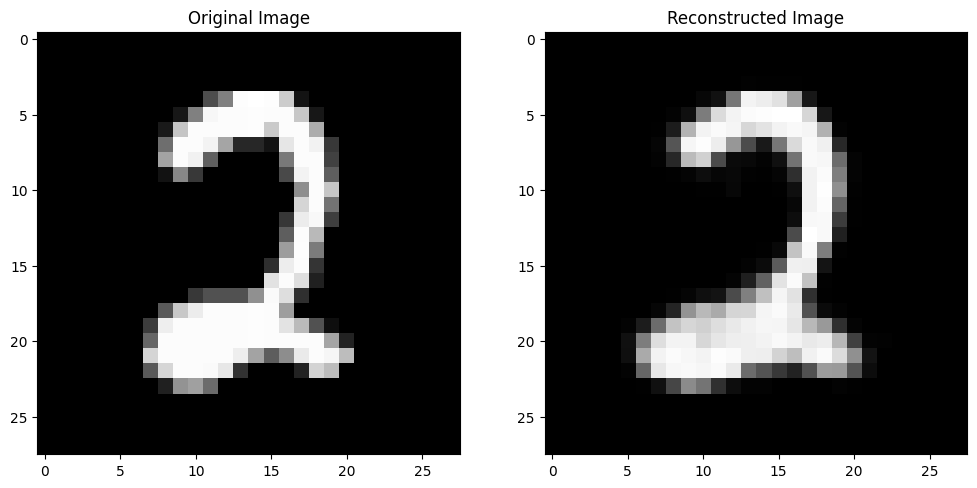

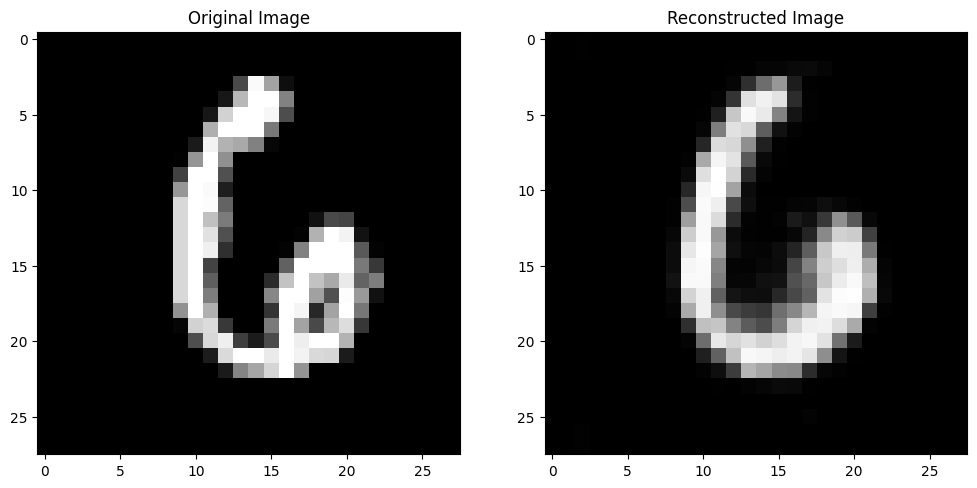

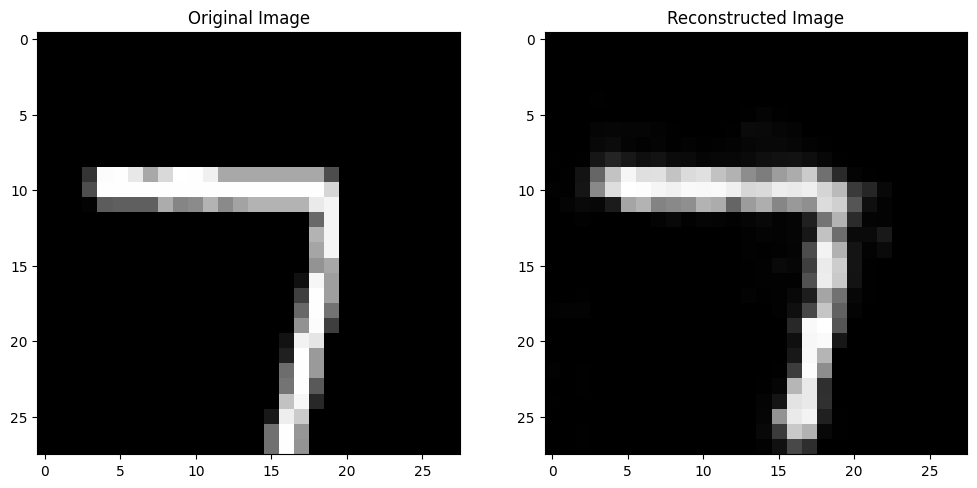

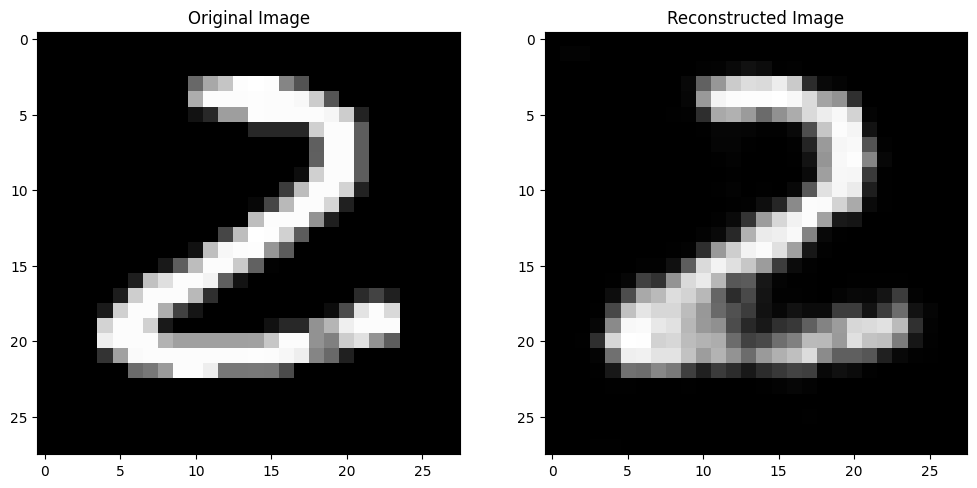

In [20]:
for _ in range (10):
    image_index = np.random.randint(0, len(valid_dataset))
    image,_ = valid_dataset[image_index]
    output_image = model(image)[0]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].cpu().detach().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(output_image.cpu().detach().numpy(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()
    